In [1]:
import xgboost as xgb
import sys

#sys.path.insert(0, '/home/wygos/sources/feature_importance/shap/build/lib.linux-x86_64-3.6/')
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lib.real_examples as real_examples
import lib.print
import lib.dump

%matplotlib inline
shap.initjs()

%load_ext autoreload
%autoreload 2

In [2]:
NAME, X, model = real_examples.get_boston()

In [3]:
print(X.shape)

(506, 13)


In [5]:
DATA_PATH=f'../data/{NAME}/'
!mkdir -p {DATA_PATH}
BST_NAME=f'{DATA_PATH}/bst_{NAME}.file'
DATA_NAME=f'{DATA_PATH}/{NAME}.csv'
SHAP_ORIG_NAME=f'{DATA_PATH}/shap_original_{NAME}.csv'


[Text(172.3028814935065, 207.55636363636364, 'X[12] <= 9.95\nentropy = 75.115\nsamples = 319\nvalue = 22.312'),
 Text(93.5510551948052, 187.7890909090909, 'X[5] <= 7.011\nentropy = 70.318\nsamples = 132\nvalue = 29.101'),
 Text(45.971590909090914, 168.0218181818182, 'X[7] <= 1.473\nentropy = 30.433\nsamples = 100\nvalue = 25.925'),
 Text(44.52224025974026, 148.25454545454545, 'entropy = 0.0\nsamples = 3\nvalue = 50.0'),
 Text(47.42094155844156, 148.25454545454545, 'X[12] <= 5.41\nentropy = 16.158\nsamples = 97\nvalue = 25.316'),
 Text(21.55909090909091, 128.48727272727274, 'X[5] <= 6.785\nentropy = 16.147\nsamples = 20\nvalue = 30.024'),
 Text(11.232467532467533, 108.72, 'X[6] <= 18.3\nentropy = 6.504\nsamples = 13\nvalue = 26.876'),
 Text(2.898701298701299, 88.95272727272729, 'X[8] <= 3.5\nentropy = 1.401\nsamples = 4\nvalue = 24.914'),
 Text(1.4493506493506494, 69.18545454545455, 'entropy = 0.0\nsamples = 1\nvalue = 26.6'),
 Text(4.348051948051948, 69.18545454545455, 'X[8] <= 4.5\nen

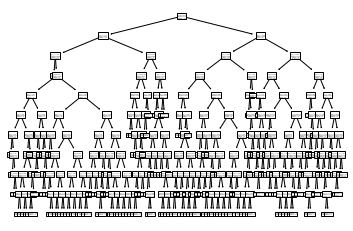

In [6]:
import sklearn
sklearn.tree.plot_tree(model.estimators_[0])

In [7]:
with open(BST_NAME, "w") as f:
    lib.dump.dump_trees(model, f, X.columns)

In [8]:
#model.dump_model(BST_NAME, with_stats=True)
pd.DataFrame(X).to_csv(DATA_NAME, index=False)


In [9]:
%%time
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X, check_additivity=False)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

CPU times: user 24.3 ms, sys: 44 µs, total: 24.3 ms
Wall time: 24 ms


In [10]:
X.iloc[61]

CRIM         0.17171
ZN          25.00000
INDUS        5.13000
CHAS         0.00000
NOX          0.45300
RM           5.96600
AGE         93.40000
DIS          6.81850
RAD          8.00000
TAX        284.00000
PTRATIO     19.70000
B          378.08000
LSTAT       14.44000
Name: 61, dtype: float64

In [11]:
#b.iloc[61]

In [12]:
%%time
#first run binary to compute values
!cd .. && make
!time ../build/shap_banzhaf b {BST_NAME} {DATA_NAME}
!time ../build/shap_banzhaf s {BST_NAME} {DATA_NAME}

make: *** No targets specified and no makefile found.  Stop.
data read
banzhaf_simple: 
banzhaf_fast: 
0.03user 0.00system 0:00.03elapsed 97%CPU (0avgtext+0avgdata 5268maxresident)k
0inputs+256outputs (0major+303minor)pagefaults 0swaps
data read
shap_simple: 
shap_fast: 
0.08user 0.00system 0:00.09elapsed 98%CPU (0avgtext+0avgdata 5472maxresident)k
0inputs+256outputs (0major+322minor)pagefaults 0swaps
CPU times: user 10.2 ms, sys: 40.7 ms, total: 50.9 ms
Wall time: 528 ms


In [13]:
#tags = ['shap_simple', 'shap_fast', 'shap_brute', 'banzhaf_simple', 'banzhaf_fast', 'banzhaf_brute']
tags = ['shap_simple', 'shap_fast', 'banzhaf_simple', 'banzhaf_fast']
feats_importances = {}
 
for t in tags:
    feats_importances[t] = pd.read_csv(f'{BST_NAME}.{t}')
    feats_importances[t] = feats_importances[t]


In [14]:
%%time
shap_original = pd.DataFrame(shap_values, columns=feats_importances['shap_simple'].columns)
feats_importances['shap_orig'] = shap_original

CPU times: user 212 µs, sys: 53 µs, total: 265 µs
Wall time: 235 µs


In [15]:
shap_original.to_csv(SHAP_ORIG_NAME, index=False)

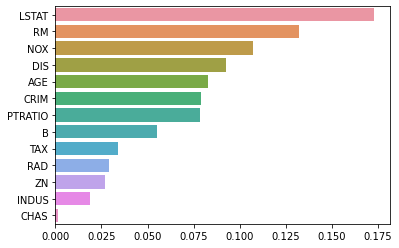

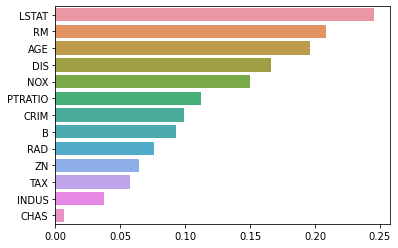

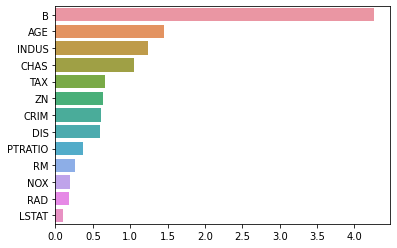

In [16]:
a=feats_importances['shap_simple']
b=feats_importances['banzhaf_fast']

lib.print.plot_vals_wide((a-b).abs().mean().to_frame().transpose(), f'{NAME}_l1')
plt.show()

plot = lib.print.plot_vals_wide(((a-b)*(a-b)).mean().apply(lambda x:np.sqrt(x)).to_frame().transpose(), f'{NAME}_l2')
plt.show()

plot = lib.print.plot_vals_wide(((a-b)/b).fillna(0).abs().mean().to_frame().transpose(), f'{NAME}_mape')
plt.show()

In [23]:
a = feats_importances['shap_orig']
b = feats_importances['shap_simple']
x= np.nan_to_num(np.abs((a - b) / b).values, nan=0, posinf=0, neginf=0)
np.mean(x)

0.006037670755693768

In [18]:
lib.print.compare_shaps(feats_importances)

max
	 {'banzhaf_fast', 'banzhaf_simple', 'shap_simple', 'shap_fast', 'shap_orig'}
banzhaf_fast ['0.00', '0.00', '620.44', '620.44', '620.44']
banzhaf_simple ['0.00', '0.00', '620.44', '620.44', '620.44']
shap_simple ['1695.91', '1695.91', '0.00', '0.00', '3.95']
shap_fast ['1695.91', '1695.91', '0.00', '0.00', '3.95']
shap_orig ['1695.91', '1695.91', '9.02', '9.02', '0.00']


argmax
	 {'banzhaf_fast', 'banzhaf_simple', 'shap_simple', 'shap_fast', 'shap_orig'}
banzhaf_fast ['0.00', '0.00', '6406.00', '6406.00', '6406.00']
banzhaf_simple ['0.00', '0.00', '6406.00', '6406.00', '6406.00']
shap_simple ['2468.00', '2468.00', '0.00', '0.00', '755.00']
shap_fast ['2468.00', '2468.00', '0.00', '0.00', '755.00']
shap_orig ['2468.00', '2468.00', '162.00', '162.00', '0.00']


mean
	 {'banzhaf_fast', 'banzhaf_simple', 'shap_simple', 'shap_fast', 'shap_orig'}
banzhaf_fast ['0.00', '0.00', '0.63', '0.63', '0.63']
banzhaf_simple ['0.00', '0.00', '0.63', '0.63', '0.63']
shap_simple ['0.89', '0.89', '0.

In [25]:
nr=755
a.values[nr//13][nr%13], b.values[nr//13][nr%13]


(0.008845831582234471, -0.026131599999999998)

In [21]:
for limit in [1,3,10,20]:
    print("imit = ", limit)
    lib.print.compare_transpositions(feats_importances, limit)

imit =  1
mean
	 ['shap_simple', 'shap_fast', 'banzhaf_simple', 'banzhaf_fast', 'shap_orig']
shap_simple ['0.00', '0.00', '0.00', '0.00', '0.00']
shap_fast ['0.00', '0.00', '0.00', '0.00', '0.00']
banzhaf_simple ['0.00', '0.00', '0.00', '0.00', '0.00']
banzhaf_fast ['0.00', '0.00', '0.00', '0.00', '0.00']
shap_orig ['0.00', '0.00', '0.00', '0.00', '0.00']
max
	 ['shap_simple', 'shap_fast', 'banzhaf_simple', 'banzhaf_fast', 'shap_orig']
shap_simple [0, 0, 0, 0, 0]
shap_fast [0, 0, 0, 0, 0]
banzhaf_simple [0, 0, 0, 0, 0]
banzhaf_fast [0, 0, 0, 0, 0]
shap_orig [0, 0, 0, 0, 0]
argmax
	 ['shap_simple', 'shap_fast', 'banzhaf_simple', 'banzhaf_fast', 'shap_orig']
shap_simple [464, 464, 464, 464, 464]
shap_fast [464, 464, 464, 464, 464]
banzhaf_simple [464, 464, 464, 464, 464]
banzhaf_fast [464, 464, 464, 464, 464]


KeyboardInterrupt: 

shap_simple


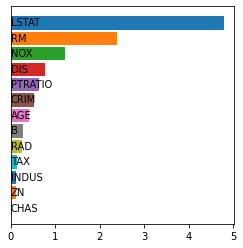

shap_fast


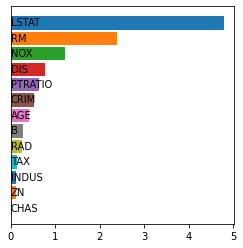

banzhaf_simple


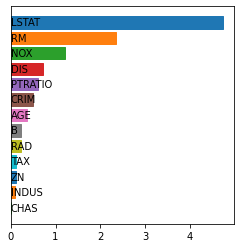

banzhaf_fast


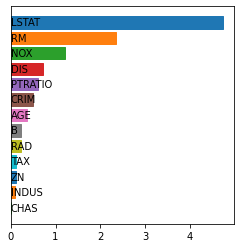

shap_orig


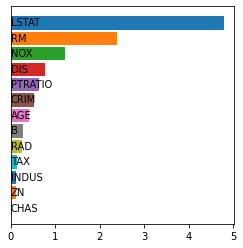

In [27]:
for t,df in feats_importances.items():
    print(t)
    plot = lib.print.plot_vals(df, f'{NAME}_{t}')
    #plot.get_figure().savefig(f'.png', bbox_inches='tight')
    plt.show()